## Discrete Fourier Transform
_CYBR 304 & MATH 420_ <br>
Spring 2024 <br>

The discrete Fourier transform (DFT) multiplies a matrix times a column vector. The matrix is a Vandermonde matrix that has a special structure. For the definition of this
particular Vandermonde matrix, see https://en.wikipedia.org/wiki/Discrete_Fourier_transform.

There are algorithms that take advantage of the special structure of the matrix to do the matrix multiplication superfast, but for educational purposes, let us first look at a slow, but straightforward way to find the DFT.  After that, we'll use an award-winning Julia package `FFTW` for finding the DFT.

This worksheet uses the DFT to find approximations to the continous least squares fit of a function to trigonometric basis functions. Much is this work is similar to the vast and well-developed topic of signal processing. Signal procoessing is based on trignonmetric polynomial interpolation, not the continous least squares fit. But there is a great deal of overlap between these approaches.

We'll use the Julia function `cis`.  The formula for this function is $\mathrm{cis}(x) = \cos(x) + \mathrm{i} \sin(x)$. The range of the `cis` function is the unit circle.  

Let's start by loading Gadfly and defining a theme for Gadfly plots.


In [2]:
using Gadfly

In [3]:
Gadfly.push_theme(:dark)

First, our pokey slow, but two line straightforward method:

In [5]:
function slow_fft(a)
    n = length(a)
    [cis(-2*pi*i*j/n) for i = 0:n-1, j=0:n-1]*a
end;

And let's try an example

In [7]:
slow_fft([1,2,3,4])

4-element Vector{ComplexF64}:
                10.0 + 0.0im
 -2.0000000000000004 + 1.9999999999999996im
                -2.0 - 9.797174393178824e-16im
 -1.9999999999999982 - 2.000000000000001im

The Julia package `FFTW` (fastest Fourier Transform in the West) is a highly efficient package for computing the DFT. Of course, the first time you use this package, you will need to use the package manager install it. Let's try it

In [9]:
using FFTW

In [10]:
fft([1,2,3,4])

4-element Vector{ComplexF64}:
 10.0 + 0.0im
 -2.0 + 2.0im
 -2.0 + 0.0im
 -2.0 - 2.0im

Here the value given by `fft` is accurate to all decimal places, but the value given by `slow_fft` isn't. To observe the speed advantage of the `fft`, we'll need to use a larger value for the value of $N$.

In [12]:
a = [1/k for k = 1:2^10];

In [13]:
@time slow_fft(a);

  0.064999 seconds (35.38 k allocations: 18.431 MiB, 46.40% compilation time)


In [14]:
@time fft(a);

  0.005979 seconds (1.26 k allocations: 118.547 KiB, 98.00% compilation time)


The FFTW method is faster, more accurate, and uses less memory than does `slow_fft.` Usually, I say that if we can't do better than everybody else, we are losers. For DFT code, let's be content being losers--the FFTW code is _very_ clever. So let's abandon our slow and not particularly accurate code.

Let's say that for a real valued function $F$ and a positive integer $N$, we have found the DFT of the finite sequence 
$F(x_0), F(x_1), F(x_2), \dots , F(x_{N-1})$, where $x_k= 2 \pi k / N$ and from that we want to reconstruct the function $F$. 

Remember that we used the right-point rule integration to approximate the true value of the Fourier coefficients. Specifically
$$
   c_k = \int_0^{2 \pi} e^{-\mathrm{i} k x} F(x) \mathrm{d} x \approx \frac{1}{n} \sum_{\ell=0}^{n-1} e^{-\mathrm{i} k x_\ell} F(x_\ell),
$$
where $x_\ell = \frac{2 \pi \ell}{n}$. For `large` values of $k$, the integrand oscillates rapidly, so the right-point rule looses accuracy. At the end of this worksheet,
there is an example that shows this loss of accuracy. To account for this loss of accuracy, when we reconstruct the function, we will not use all the Fourier coefficients. 

To reconstruct the function from the Fourier coefficients, we'll use a slow, but straightforward method. If we only needed the find the values of the function at
the knots, we could use the inverse of the FFT.  

For efficiency, we use the fact that $\mathrm{cis}((𝑘+1)𝑥)= \mathrm{cis}(𝑥) \mathrm{cis}(𝑘𝑥)$ to reconstruct a function given its Fourier coefficients follows. If you despise Julia's one-based arrays, notice that this version does not use brackets to access array elements.

In [15]:
"""
    DFT_to_fn(x::Real, a::Array)

Compute the value of a real valued function at `x` given its Fourier coefficients stored in the array `a`.
"""
function DFT_to_fn(x::Real,a::Array)
    s = zero(x)
    z = cis(x)
    q = one(eltype(a))
    for ak in a
        s += real(ak*q)
        q *= z
    end
    2*s - real(first(a)) 
end;

Let's try this out. 

In [17]:
function F(x) 
  -8*sin(x) + 10*cos(2*x)
end;

In [18]:
N = 16;

In [19]:
a = fft([F(2*pi*k/N) for k=0:N-1])/N;

Let's retain one half of the Fourier coefficients

In [21]:
a = a[1:div(N,2)];

The graphs of $F$ and the function determined by the DFT are so close together, we can't tell them apart.  Actually, since our function is exactly a sum of sinusoidal functions with periods $2 \pi$, it's not a coincidence they are 

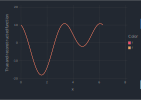

In [23]:
p = plot([F, x -> DFT_to_fn(x,a)],0,2*pi, Guide.xlabel("x"), Guide.ylabel("True and reconstructed function"))

Here is a graph of the difference between the function $F$ and the function we reconstructed from the DFT. It's a crazy looking graph, but the differences have a magnitude that are of the order $10^{-14}$. So for this case, our code seems to work OK.

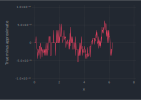

In [25]:
plot(x -> F(x) - DFT_to_fn(x,a),0,2*pi, Guide.xlabel("x"), Guide.ylabel("True minus approximate"))

Let's try a few other functions!

In [27]:
N = 2^12

4096

In [28]:
F(x) = abs(x-pi)

F (generic function with 1 method)

In [29]:
a = fft([F(2*pi*k/N) for k=0:N-1])/N;

In [30]:
a = a[1:div(N,2)];

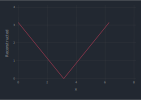

In [31]:
plot([x -> DFT_to_fn(x,a)],0,2*pi, Guide.xlabel("x"), Guide.ylabel("Reconstructed"))

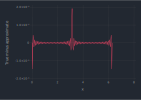

In [32]:
plot([x -> F(x) - DFT_to_fn(x,a)],0,2*pi,Guide.xlabel("x"), Guide.ylabel("True minus approximate"))

Let's have some fun. To the function $x \mapsto  -8 \sin(x) + 10 \cos(2 x)$, let's add some randomness. If we were in a music studio recording, the function
 $x \mapsto  -8 \sin(x) + 10 \cos(2 x)$ represents to a sound with different amplitudes and two frequencies one octave apart. And the randomness would represent a higher
 frequency noise. To get consistent results from our function $F$, we'll set the seed for the random number generator. Here is our function

In [34]:
using Random
seed_value = 0
Random.seed!(seed_value);

In [35]:
function F(x) 
      -8*sin(x) + 10*cos(2*x) + 10*(rand()-0.5)/4
end

F (generic function with 1 method)

In [36]:
a = fft([F(2*pi*k/N) for k=0:N-1])/N;

In [37]:
a = a[1:div(N,2)];

Both the function $F$ and the function we reconstruct from the DFT have crazy wiggles in them from the noise

In [39]:
Random.seed!(seed_value);

In [40]:
p = plot([F, x -> DFT_to_fn(x,a)],0,2*pi, Guide.xlabel("x"), Guide.ylabel("True and reconstructed"));

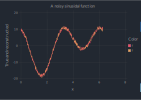

In [41]:
push!(p, Guide.title("A noisy sinusidal function"))

We can get rid of the high frequency noise by reducing the magnitude of the value of the DFT for the higher frequency terms. We'll do this by appending a function to our function that multiplies the discrete Fourier coefficients

In [43]:
function DFT_to_fn(x::Real,a::Array,fn::Function)
    s = fn(0)*real(a[1])
    for k = 1 : length(a)-1
        s += 2*fn(k)*real(a[k+1]*cis(k*x))
    end
    s
end;

In [44]:
"""
    DFT_to_fn(x::Real, a::Array)

Compute the value of a real valued function at `x` given its Fourier coefficients stored in the array `a`.
"""
function DFT_to_fn(x::Real,a::Array, fn::Function)
    s = zero(x)
    z = cis(x)
    q = one(eltype(a))
    k = 0
    for ak in a
        s += fn(k)*real(ak*q)
        q *= z
        k += 1
    end
    2*s - real(first(a)) 
end;

In [45]:
Random.seed!(seed_value);

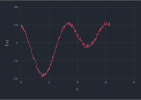

In [46]:
plot([F],0,2*pi)

In [47]:
p = plot(x -> DFT_to_fn(x,a, k -> if k < 50 1 else 0 end),0,2*pi);

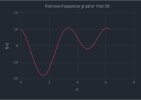

In [48]:
push!(p, Guide.title("Remove frequences greater than 50"))

If we remove all frequencies greater than 8, our reconstructed function is a bit less "wiggly."

In [49]:
p = plot(x -> DFT_to_fn(x,a, k -> if k < 8 1 else 0 end),0,2*pi);

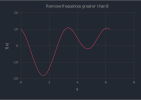

In [50]:
push!(p, Guide.title("Remove frequences greater than 8"))

Or we can gradually reduce the amplitude of the higher frequencies; for example

In [51]:
Random.seed!(seed_value);

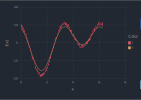

In [52]:
p = plot([F, x -> DFT_to_fn(x,a, k -> exp(-k/10))],0,2*pi)

In [53]:
Random.seed!(seed_value);

We can filter out all frequencies except frequency one using a filter that sets all Fourier coefficients except the coefficient of $\mathrm{e}^{i x}$ to zero.

In [55]:
p = plot([F, x -> DFT_to_fn(x,a, k -> if k == 1 1 else 0 end)],0,2*pi);

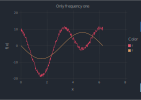

In [56]:
push!(p, Guide.title("Only frequency one"))

In [57]:
Random.seed!(seed_value);

And the same for the frequency two

In [59]:
p= plot([F, x -> DFT_to_fn(x,a, k -> if k == 2 1 else 0 end)],0,2*pi);

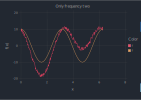

In [60]:
push!(p, Guide.title("Only frequency two"))

In [61]:
Random.seed!(seed_value);

Here let us look at an example that compares the true value of the Fourier coefficients to the value determined using the right point rule integration. It's not much fun to prove, but for the function $F(x) = |x - \pi|$, we have
$$
   c_k = \frac{1}{2 \pi} \int_0^{2 \pi} e^{-\mathrm{i} k x} | x - \pi| \, \mathrm{d} x = \frac{1}{2 \pi} \begin{cases} \frac{2}{{{k}^{2}}}-\frac{2 {{\left( -1\right) }^{k}}}{{{k}^{2}}} & k \neq 0 \\
                                                                                                    \pi^2 & k = 0
                                                                                     \end{cases}  
$$
Let's compare the true value with the value determined by right-point rule integration.

In [63]:
F(x) = abs(x-pi);

In [64]:
N =  32

32

In [65]:
a = fft([F(2*pi*k/N) for k=0:N-1])/N;

In [66]:
b = [if k==0 pi^2 else 2/k^2-(2*(-1)^k)/k^2 end for k=0:N-1]/(2*pi);

The graph of the difference between the true value and the values determined by right point rule integration shows that the difference grows for the higher frequencies. The graph of the difference for the imaginary parts shows they are about the same.

In [68]:
p = plot(x = [k for k=1:N], y=real(a-b), Guide.xlabel("k"), Guide.ylabel("difference"));

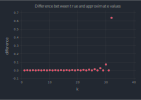

In [69]:
push!(p, Guide.title("Difference between true and approximate values"))

Finally, just for fun, I asked chatGPT to write Julia code that would evaluate a function given its Fourier coefficients. After a few rounds of asking for improvements,
chatGPT gave me this code. The construct `for (k, ak) in enumerate(a)` is both interesting and new to me and the type declaration for the array is more specific than what I used, but the code is broken and fixing it seems harder than starting from scratch. 

In fairness to chatGPT, maybe if had gone a few more rounds of asking for improvements, the code would work correctly.

To pick on chatGPT a bit more, the code finds the length of the array argument, but it never uses the length. That's never a good sign.

In [71]:
"""
    evaluate_fourier_at_x(x::Real, a::AbstractArray{<:Complex{T}}) where T<:Real

Evaluate the function represented by its Fourier coefficients at a given value `x`.

# Arguments
- `x::Real`: The point at which to evaluate the function.
- `a::AbstractArray{<:Complex{T}}`: Coefficients of the function's Fourier series.

# Returns
- The value of the function at point `x`.

# Example
```julia
a = [1.0 + 2.0im, 3.0 - 1.0im, 2.0 + 4.0im]
evaluate_fourier_at_x(0.5, a)  # Returns the value of the function at x = 0.5
"""

function evaluate_real_fourier_at_x(x::Real, a::AbstractArray{<:Complex{T}}) where T<:Real
   n = length(a)
   result = zero(T)
   for (k, ak) in enumerate(a)
         result += real(ak) * cos(2π * (k - 1) * x) - imag(ak) * sin(2π * (k - 1) * x)
   end
   return result
end;


In [72]:
N = 32

32

In [73]:
a = fft([sin(2*pi*k/N) for k=0:N-1])/N;

In [74]:
(sin(0.23), DFT_to_fn(0.23,a[1:16]), evaluate_real_fourier_at_x(0.23,a[1:16]))

(0.2279775235351884, 0.22797752353518838, 0.49605735065723894)